# Labb 2 - Pandas och data processing

This code analyzes Swedish national test results and grade statistics for 9th grade students.
Course: Artificial intelligence 1 - Python

## Data Sources
* National test results from different subjects (riket2023_åk9_np.xlsx)
* National grade statistics (betyg_o_prov_riksnivå.xlsx)

## Sources used:
* Create folder. https://www.freecodecamp.org/news/creating-a-directory-in-python-how-to-create-a-folder/
* Missing data, convert to numrics values, dropna. https://www.geeksforgeeks.org/working-with-missing-data-in-pandas/

## Techniques from some of lectures
* Reading Excel files: pd.read_excel() with parameters like skiprows, header and sheet_name
* Converting values to numeric: pd.to_numeric(..., errors='coerce) with error handling
* Styling Seaborn graphs: sns.set(style="whitegrid")
* Creating subplot grids: plt.subplots(2, 2, figsize=(14, 10))
* Layout adjustment: plt.tight_layout()
* Removing unnecessary elements: axes[i].spines[spine].set_visible(False)
* Creating interactive line graphs: go.Scatter() and go.Figure()
* Multiple plots in one figure: make_subplots()
* Layout customization: fig.update_layout()

AI assistance: ChatGPT


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import os

from IPython.display import display
from plotly.subplots import make_subplots

In [12]:
# Create folder visualiseringar if not exists. 
if not os.path.exists("visualiseringar"):
    os.makedirs("visualiseringar")

In [13]:
""" 
Task 1: Visualize data with matplotlib

1a) This function loads data from the Excel file containing results from different subjects,
and rename columns to a standardized format for easier analysis.
"""
def load_np_data(file_path="data/riket2023_åk9_np.xlsx" ):
    # List of subjects to analyze
    subjects = ['Engelska', 'Matematik', 'Svenska', 'Svenska som andraspråk']
    # Empty dictionary to store dataframes for each subject
    dfs = {}
    # Iterate over subjects
    for subject in subjects:
        # Read data from excel file
        df = pd.read_excel(file_path, sheet_name=subject, header=None, skiprows=9, nrows=5)
        # Define new column names for the dataframe
        new_column_name = ['Plats', 'Huvudman', 'Totalt (A-F)', 'Flickor (A-F)', 'Pojkar (A-F)',
                           'Totalt (A-E)', 'Flickor (A-E)', 'Pojkar (A-E)',
                           'Totalt (poäng)', 'Flickor (poäng)', 'Pojkar (poäng)']
        # Set new column names
        df.columns = new_column_name
        
        df.replace("..", pd.NA, inplace=True)
        # Convert numerical columns to numeric type
        numeric_columns = ['Totalt (A-F)', 'Flickor (A-F)', 'Pojkar (A-F)',
                           'Totalt (A-E)', 'Flickor (A-E)', 'Pojkar (A-E)',
                           'Totalt (poäng)', 'Flickor (poäng)', 'Pojkar (poäng)']
        for col in numeric_columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Fill missing values with "Ej Tillgängligt"
        df = df.astype(object)  # Converts all columns to object type (string-compatible)
        df.fillna("Data saknas", inplace=True)
        
        # Add subject dataframe to dictionary
        dfs[subject] = df
    return dfs

In [14]:
""" 
Task 1: Visualize data with matplotlib

Loading and displaying data for all subjects from national exams with formatted Jupyter Notebook output.
"""
def display_all_subjects(file_path="data/riket2023_åk9_np.xlsx"):

    pd.set_option("display.max_columns", None)  # Shows all columns
    pd.set_option("display.width", 200)         # Make terminan print bigger Bredda terminalutskrift
    # Define which sheets to read
    subjects = ['Engelska', 'Matematik', 'Svenska', 'Svenska som andraspråk']
    # Create a dictionary to store data for each subject
    dfs = {}

    for subject in subjects:
        # Read data from the correct sheet (first 5 rows after header)
        df = pd.read_excel(file_path, sheet_name=subject, header=None, skiprows=9, nrows=5)
        
        # Definiera MultiIndex-kolumner (rubriker och underrubriker)
        columns = [
            ("Plats", ""), 
            ("Huvudman", ""),
            ("Totalt", "(A-F)"), ("Flickor", "(A-F)"), ("Pojkar", "(A-F)"),
            ("Totalt", "(A-E)"), ("Flickor", "(A-E)"), ("Pojkar", "(A-E)"),
            ("Totalt", "(poäng)"), ("Flickor", "(poäng)"), ("Pojkar", "(poäng)")
        ]
        
        # Create MultiIndex
        df.columns = pd.MultiIndex.from_tuples(columns)
        # Replace ".." with NaN
        df.replace("..", pd.NA, inplace=True)
        # Convert numeric columns
        numeric_columns = [col for col in df.columns if col[1] in ["(A-F)", "(A-E)", "(poäng)"]]
        for col in numeric_columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
        # Spara tabellen i dictionary
        dfs[subject] = df
    # For Jupyter Notebook - display formatted tables for all subjects
    for subject in subjects:
        print(f"\n=== {subject} ===")
        styled_df = dfs[subject].style.set_table_styles([
            {'selector': 'th', 'props': [('font-weight', 'bold'), ('background-color', 'white'), ('color', 'black')]},
            {'selector': 'td', 'props': [('background-color', 'white'), ('color', 'black')]},
            {'selector': '.index_name', 'props': [('font-weight', 'bold')]},
            {'selector': '.row_heading', 'props': [('font-weight', 'normal')]},
            {'selector': 'tbody tr:nth-child(1), tbody tr:nth-child(2), tbody tr:nth-child(3)', 'props': [('border-bottom', '1px solid black')]},
            {'selector': 'td.col1', 'props': [('text-align', 'left')]}
        ]).set_properties(**{
            **{str(('Plats', '')): "text-align: left;"},
            **{str(('Huvudman', '')): "text-align: left;"},
            **{str(col): "text-align: center;" for col in numeric_columns}
        }).format({
            col: lambda x: (
                "Ej data" if pd.isna(x) else
                f"{int(x)}" if x == int(x) else
                f"{x:.1f}"
            ) for col in numeric_columns
        })
        display(styled_df)  # Display the table in Jupyter Notebook
    
    return dfs

In [15]:
""" 
1b) Visualize average grade across different schools authorities for each subject.

This function creates a grid of bar charts showing the average grade points for different schools authorities across all subjects.
Each chart includes data labels, appropriate titles, and annotations for missing data.
"""
def plot_subject_scores(data):
    # Check if data is available
    if not data:
        print("Ingen data tillgänglig")
        return
    # Set seaborn style
    sns.set(style="whitegrid")
    # Create figure and axes
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    # Iterate over subjects and create bar charts
    for i, (subject, df) in enumerate(data.items()):
        # Check if DataFrame has MultiIndex columns structure
        has_multiindex = isinstance(df.columns, pd.MultiIndex)
        # Get the column names for 'Huvudman' and 'Totalt poäng' based on the dataframe structure
        if has_multiindex:
            huvudman_col = ('Huvudman', '')
            total_poang_col = ('Totalt', '(poäng)')
        else:
            huvudman_col = 'Huvudman'
            total_poang_col = 'Totalt (poäng)'
        # Convert score columns to numeric values, replacing non-numeric values with NaN
        df[total_poang_col] = pd.to_numeric(df[total_poang_col], errors='coerce')
        # Remove rows with NaN values in 'Totalt (poäng)' column
        df_clean = df.dropna(subset=[total_poang_col])
        # Create temporary DataFrame for seaborn visualization
        temp_df = pd.DataFrame({
            'Huvudman': df_clean[huvudman_col],
            'Totalt (poäng)': df_clean[total_poang_col]
        })
        # Define color palette dynamically
        unique_huvudman = df_clean['Huvudman'].nunique()
        palette = sns.color_palette("tab10", unique_huvudman)
        # Create bar plot with seaborn
        bars = sns.barplot(
            x='Huvudman', 
            y='Totalt (poäng)', 
            hue='Huvudman', 
            data=temp_df,
            ax=axes[i], 
            legend=False
        )
        # Add labels to each bar
        for bar in bars.patches:
            height = bar.get_height()
            axes[i].text(bar.get_x() + bar.get_width()/2, height + 0.1, 
                       f'{height:.1f}', ha='center', va='bottom', fontweight='bold')
        # Set titles and labels
        axes[i].set_title(f'Totalpoäng för {subject}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel('Huvudman', fontsize=10, fontweight='bold')
        axes[i].set_ylabel('Genomsnittlig poäng', fontsize=9, fontweight='bold')
        # Add annotation if Skolverket data is missing for Svenska som andraspråk
        if subject == 'Svenska som andraspråk' and 'Skolverket' not in temp_df['Huvudman'].values:
            axes[i].annotate("Data för Skolverket ej tillgänglig", 
                    xy=(0.65, 0.98),
                    xycoords="axes fraction", 
                    fontsize=9,      
                    color="#333333", 
                    ha='right',
                    va='top',
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
                   )
        # Add annotation about missing Skolverket (A-E) data for Matematik
        if subject == 'Matematik':
            axes[i].annotate("Data för Skolverket (A-E) ej tillgänglig", 
                    xy=(0.66, 0.98),
                    xycoords="axes fraction", 
                    fontsize=9,      
                    color="#333333", 
                    ha='right',
                    va='top',
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
                    )
        # Remove top and right spines
        for spine in ['top', 'right']:
            axes[i].spines[spine].set_visible(False)
        # Set y-axis limits with space for labels
        if not df_clean.empty:
            current_ymax = max(df_clean['Totalt (poäng)'])
            axes[i].set_ylim(0, current_ymax * 1.15)
    # Add main title
    plt.suptitle('Genomsnittlig poäng per huvudman för olika ämnen', fontsize=16, fontweight='bold', y=0.95)
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    # Save plot as image png-file
    plt.savefig('visualiseringar/np_totalpoang_per_huvudman.png', dpi=300, bbox_inches='tight')
    plt.show()

In [16]:
""" 
Task 2: Analyze national grade and data

This function loads data from the file betyg_o_prov_riksnivå.xlsx. And extract three key metrics
- Percentage of students missing passing grade
- Average merit value
- Parental education background data for additional analysis 
"""
def load_betyg_data(file_path="data/betyg_o_prov_riksnivå.xlsx"):
    try:
        # Read data from excel file
        df_1b = pd.read_excel(file_path, sheet_name="Tabell 1B", header=None)
        # Extract data from the dataframe and return it
        saknar_godkant = df_1b.iloc[8:13, [0, 7, 8, 9]].copy()
        saknar_godkant.columns = ['Läsår', 'Totalt', 'Flickor', 'Pojkar']
        # Extract merit value data
        meritvarde = df_1b.iloc[8:13, [0, 1, 2, 3]].copy()
        meritvarde.columns = ['Läsår', 'Totalt', 'Flickor', 'Pojkar']
        # Search for parent education background data
        utbildning_row = None
        for i in range(len(df_1b)):
            cell_value = str(df_1b.iloc[i, 0]) if not pd.isna(df_1b.iloc[i, 0]) else ""
            if "utbildning" in cell_value.lower() and "föräld" in cell_value.lower():
                utbildning_row = i
                print(f"Hittade rad med föräldrars utbildning: {i}")
                break
        # If parent education data found, extract it
        utbildning_data = None
        if utbildning_row:
            utbildning_data = df_1b.iloc[utbildning_row+1:utbildning_row+6, [0, 1, 7]].copy()
            utbildning_data.columns = ['Utbildningsbakgrund', 'Meritvärde', 'Andel saknar godkänt']
            utbildning_data = utbildning_data.dropna(subset=['Utbildningsbakgrund'])
        # return extracted data as a dictionary
        return {
            'saknar_godkant': saknar_godkant,
            'meritvarde': meritvarde,
            'utbildning': utbildning_data
        }
    except Exception as e:
        print(f"Ett fel uppstod vid inläsning av betygdata: {e}")
        return None

In [17]:
"""
2a) Longitudinal analysis of academic performance gaps

This function visualizes and tracks the percentage of students missing passing grade over time (2018-2023),
comparing performance across gender groups. And saves the figure as HTML file.
"""
def plot_saknar_godkant(df):
    if df is None:
        print("Ingen data tillgänglig för att skapa visualisering")
        return
    # Convert columns to numeric values
    for col in ['Totalt', 'Flickor', 'Pojkar']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    # Create figure with plotly
    fig = go.Figure()
    # Add lines for Total, Flickor and Pojkar
    fig.add_trace(go.Scatter(x=df['Läsår'], y=df['Totalt'], mode='lines+markers', name='Totalt', line=dict(color='blue', width=2)))
    fig.add_trace(go.Scatter(x=df['Läsår'], y=df['Flickor'], mode='lines+markers', name='Flickor', line=dict(color='red', width=2)))
    fig.add_trace(go.Scatter(x=df['Läsår'], y=df['Pojkar'], mode='lines+markers', name='Pojkar', line=dict(color='green', width=2)))
    # Update layout
    fig.update_layout(title='Andel elever som saknar godkänt betyg i ett eller flera ämnen (2018/19-2022/23)', xaxis_title='Läsår', yaxis_title='Andel elever (%)', hovermode='x unified', template='plotly_white')
    # Save figure as HTML
    fig.write_html("visualiseringar/saknar_godkant_betyg.html")
    print("Figur för andel godkända betyg skapad och sparad som HTML-fil (saknar_godkant_betyg.html)")
    return fig

In [18]:
"""
2b) Trend analysis of Academic merit values

This function visualizes and tracks average merit values acros 16 subjects over time (2018-2023),
comparing performance metrics between different demographic groups. And save the figure as HTML file.
"""
def plot_meritvarde(df):
    if df is None:
        print("Ingen data tillgänglig för att skapa visualisering")
        return
    for col in ['Totalt', 'Flickor', 'Pojkar']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    # Create figure with plotly    
    fig = go.Figure()
    # Add lines for Totalt, Flickor and Pojkar
    fig.add_trace(go.Scatter(x=df['Läsår'], y=df['Totalt'], mode='lines+markers', name='Totalt', line=dict(color='blue', width=2)))
    fig.add_trace(go.Scatter(x=df['Läsår'], y=df['Flickor'], mode='lines+markers', name='Flickor', line=dict(color='red', width=2)))
    fig.add_trace(go.Scatter(x=df['Läsår'], y=df['Pojkar'], mode='lines+markers', name='Pojkar', line=dict(color='green', width=2)))
    # Update layout
    fig.update_layout(title='Medelmeritvärde för 16 ämnen (2018/19-2022/23))', xaxis_title='Läsår', yaxis_title='Medelmeritvärde', hovermode='x unified', template='plotly_white')
    fig.write_html("visualiseringar/meritvarde_16_amnen.html")
    print("Figur för meritvärde skapad och sparad som HTML-fil (meritvarde_16_amnen.html)")
    return fig

In [19]:
""" 
2c) Parental education background and student performance analysis

This function visualizes the impact of parental education background on student performance,
comparing average merit values and percentage of students missing passing grade. And saves the figure as HTML file.

The dual-panel visualization enables direct comparison of these relationships.
 """
def plot_utbildningsbakgrund(df):
    if df is None:
        print("Ingen data tillgänglig för att skapa visualisering")
        return
    # Filter out rows with invalid values, such as the 'därav' row
    df =df[df['Utbildningsbakgrund'] != 'därav'].copy()
    # Convert columns to numeric
    df['Meritvärde'] = pd.to_numeric(df['Meritvärde'], errors='coerce')
    df['Andel saknar godkänt'] = pd.to_numeric(df['Andel saknar godkänt'], errors='coerce')
    # Create a subplot with two graphs
    fig = make_subplots(rows=2, cols=1, subplot_titles=('Medelmeritvärde per föräldrars utbildningsbakgrund', 'Andel som saknar godkänt betyg per föräldrars utbildningsbakgrund'), vertical_spacing=0.25)
    # Graph for - meritvärde
    fig.add_trace(go.Bar(x=df['Utbildningsbakgrund'], y=df['Meritvärde'], name='Medelmeritvärde', marker=dict(color='skyblue')), row=1, col=1)
    # Graph for - andel saknar godkänt
    fig.add_trace(go.Bar(x=df['Utbildningsbakgrund'], y=df['Andel saknar godkänt'], name='Andel saknar godkänt', marker=dict(color='coral')), row=2, col=1)
    # Update layout
    fig.update_layout(title_text='Föräldrars utbildningsbakgrunds påverkan på skolresultat (2022/23)', height=800, showlegend=False, template='plotly_white')
    # Update y-axis titles
    fig.update_yaxes(title_text='Medelmeritvärde', row=1, col=1)
    fig.update_yaxes(title_text='Andel (%)', row=2, col=1)
    # Save figure as HTML
    fig.write_html("visualiseringar/utbildningsbakgrund_analys.html")
    print("Figur för föräldrars utbildningsbakgrund skapad och sparad som HTML-fil (utbildningsbakgrund_analys.html)") 
    return fig


 --- Uppgift 1: Nationella prov ---

=== Engelska ===


,Plats,Huvudman,Totalt,Flickor,Pojkar,Totalt,Flickor,Pojkar,Totalt,Flickor,Pojkar
,,,(A-F),(A-F),(A-F),(A-E),(A-E),(A-E),(poäng),(poäng),(poäng)
0,Riket,Samtliga,106941,51864,55077,97,97.1,97,15.7,15.8,15.7
1,Riket,Kommunal,84310,40675,43635,96.6,96.6,96.6,15.4,15.5,15.4
2,Riket,Enskild,22582,11165,11417,98.7,98.8,98.7,16.9,17,16.8
3,Riket,Skolverket,49,24,25,100,100,100,18.5,18.9,18.2



=== Matematik ===


,Plats,Huvudman,Totalt,Flickor,Pojkar,Totalt,Flickor,Pojkar,Totalt,Flickor,Pojkar
,,,(A-F),(A-F),(A-F),(A-E),(A-E),(A-E),(poäng),(poäng),(poäng)
0,Riket,Samtliga,106766,51548,55218,89.1,88.7,89.5,11.9,11.8,12
1,Riket,Kommunal,84163,40386,43777,88.1,87.7,88.5,11.6,11.5,11.7
2,Riket,Enskild,22553,11137,11416,92.9,92.2,93.5,13,12.8,13.1
3,Riket,Skolverket,50,25,25,Ej data,Ej data,Ej data,14.1,13.5,14.7



=== Svenska ===


,Plats,Huvudman,Totalt,Flickor,Pojkar,Totalt,Flickor,Pojkar,Totalt,Flickor,Pojkar
,,,(A-F),(A-F),(A-F),(A-E),(A-E),(A-E),(poäng),(poäng),(poäng)
0,Riket,Samtliga,93225,45800,47425,96.1,97.9,94.4,13.6,14.5,12.7
1,Riket,Kommunal,72771,35484,37287,95.7,97.6,93.8,13.3,14.3,12.4
2,Riket,Enskild,20414,10297,10117,97.6,98.7,96.6,14.4,15.2,13.5
3,Riket,Skolverket,40,19,21,100,100,100,15,15.9,14.2



=== Svenska som andraspråk ===


,Plats,Huvudman,Totalt,Flickor,Pojkar,Totalt,Flickor,Pojkar,Totalt,Flickor,Pojkar
,,,(A-F),(A-F),(A-F),(A-E),(A-E),(A-E),(poäng),(poäng),(poäng)
0,Riket,Samtliga,14092,6447,7645,77.7,81.6,74.3,9.4,10.2,8.7
1,Riket,Kommunal,11963,5495,6468,75.9,80,72.4,9,9.9,8.3
2,Riket,Enskild,2122,949,1173,87.7,90.9,85.2,11.1,12,10.4
3,Riket,Skolverket,Ej data,Ej data,Ej data,Ej data,Ej data,Ej data,Ej data,Ej data,Ej data


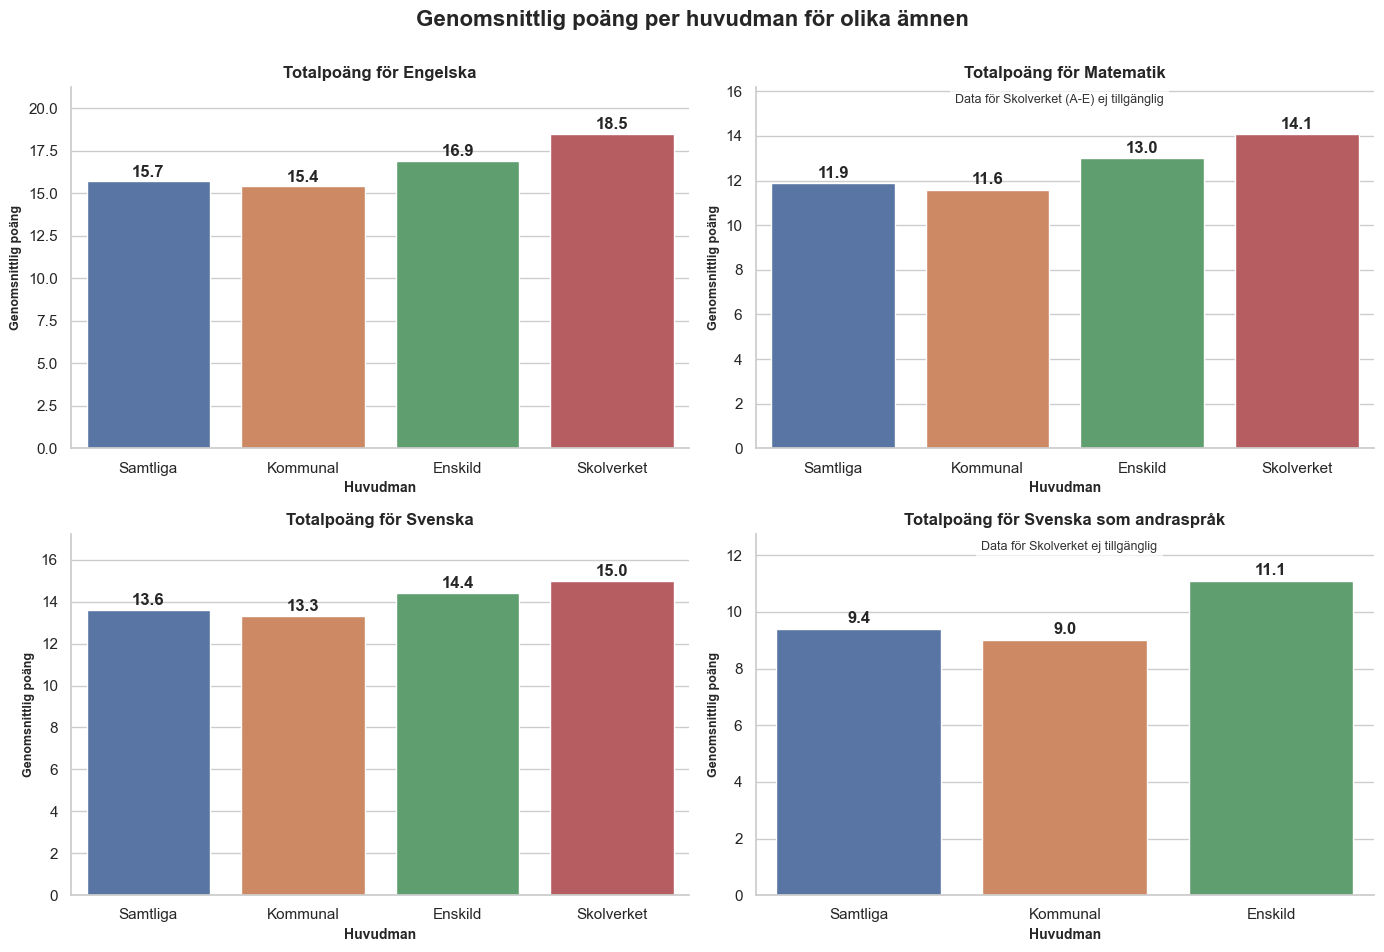


 --- Uppgift 2: Betyg och prov riksnivå ---
Hittade rad med föräldrars utbildning: 29

2a) Andel elever som saknar godkänt betyg
Figur för andel godkända betyg skapad och sparad som HTML-fil (saknar_godkant_betyg.html)

2b) Medelmeritvärde för 16 ämnen
Figur för meritvärde skapad och sparad som HTML-fil (meritvarde_16_amnen.html)

2c) Föräldrars utbildningsbakgrund
Figur för föräldrars utbildningsbakgrund skapad och sparad som HTML-fil (utbildningsbakgrund_analys.html)

Analys slutförd! Alla visualiseringar har sparats i mappen visualiseringar


In [20]:
""" 
Main function running the analyses 

This function executes the entire analysis workflow:
1. Loads and displays data from national NP
2. Creates visualizations for task 1b
3. Loads national grade statistics
4. Creates visualizations for tasks 2a, 2b, and 2c
"""
def main():
    print("\n --- Uppgift 1: Nationella prov ---")
    # Load data for NP (task 1a)
    np_data = load_np_data()
    # Display formatted tables for all subjects
    display_all_subjects()
    
    if np_data:
        # create a visualisation of the data for task 1b
        plot_subject_scores(np_data)
    
    print("\n --- Uppgift 2: Betyg och prov riksnivå ---")
    betyg_data = load_betyg_data()
    
    if betyg_data:
        
        print("\n2a) Andel elever som saknar godkänt betyg")
        plot_saknar_godkant(betyg_data['saknar_godkant'])
        
        print ("\n2b) Medelmeritvärde för 16 ämnen")
        plot_meritvarde(betyg_data['meritvarde'])
        
        print("\n2c) Föräldrars utbildningsbakgrund")
        plot_utbildningsbakgrund(betyg_data['utbildning'])
    
    print("\nAnalys slutförd! Alla visualiseringar har sparats i mappen visualiseringar")

if __name__ == '__main__':
    main()